# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data, using Theano and Keras to build the NN.

Note that the data is available from Kaggle here:  
https://www.kaggle.com/c/state-farm-distracted-driver-detection/data


## Set up the environment
First, let's import what we need and set up environment variables, etc.

In [123]:
# Imports of the relevant libraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
# Root Dir is needed for Python, but not for create lmdb shell script later... (we need it there too!)
image_root_dir = './imgs/'
train_image_source_dir = "./train/"
test_image_source_dir = "./test/"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_images_dir = "./images/train/"
#validation_images_dir = "./images/validate/" 
test_images_dir = "./images/test/"

# Some more controls
# color type: 1 - grey, 3 - rgb
color_type = 1
image_width = 80
image_height = 60

## Start by pre-processing the images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [108]:
# Training set is in the provided csv file
driver_list = pd.read_csv(driver_image_list)
print "Training data summary: \n{}".format(driver_list.head())

test_image_list = os.listdir(image_root_dir + test_image_source_dir)
print "\nTesting data summary: \n{}".format(test_list[0:9])

Training data summary: 
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Testing data summary: 
['img_1.jpg', 'img_10.jpg', 'img_100.jpg', 'img_1000.jpg', 'img_100000.jpg', 'img_100001.jpg', 'img_100002.jpg', 'img_100003.jpg', 'img_100004.jpg']


Process images so that they are in an format more suited to training and testing

In [128]:
def get_driver_images_and_classes(driver_list):
    image_list = []
    class_list = []
    total = 0
    for driver_row in [ drvr for drvr in driver_list.iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        driver_class = int(driver['classname'][1:])  # Get integer to represent class (eg 'c0' is class '0')
        image_list.append(driver['img'])
        class_list.append(driver_class)
        total += 1
    print "Total number of training images found {}".format(total)
    #Return a list of images and their classification
    return np.array(image_list), np.array(class_list)

# Create a training list of images and classes from the training set
images, classes = get_driver_images_and_classes(driver_list)

Total number of training images found 22424


In [125]:
import cv2

# Process the image, for now this is resize only
# We'll handle colour/greyscale when we load as cv2 does this for us
# TODO - Move to directory creaton to Python code to be OS independent

def pre_process_image(image):
    processed_img = cv2.resize(image, (image_width, image_height)) 
    return processed_img
    
def create_train_image_repository(images_dest_dir, images_list, class_list, color_type=1):
    print "create_image_repository(): Processing images into {}".format(images_dest_dir)
    copied = 0 
    for f, c in zip(images_list, class_list):
        dest_dir = images_dest_dir + str(c) + "/"
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + train_image_source_dir + '/c' + str(c) + '/' + f
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(images_dest_dir + str(c) + "/" + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ".",
    print "\nCopied {} images...Done!".format(copied)
    return copied

def create_test_image_repository(dest_dir, images_list, color_type=1):
    print "create_image_repository(): Processing images into {}".format(dest_dir)
    copied = 0 
    for f in images_list:
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + test_image_source_dir + f
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(dest_dir + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ".",
    print "\nCopied {} images...Done!".format(copied)
    return copied

## Pre-process images if required

In [126]:
# Start by clearing out any old data (ignore failures here if the directory doesn't exist)
# TODO - Move to Python code to be OS independent

create_repository = True    # True forces creation of the processed images, 
                            # Set to False if this has been done previously
if create_repository:
    !rm -rf $train_images_dir
    #!rm -rf $validation_images_dir
    !rm -rf $test_images_dir

    # Create directories
    !mkdir -p $train_images_dir
    #!mkdir -p $validation_images_dir
    !mkdir -p $test_images_dir

    create_test_image_repository(test_images_dir, test_image_list, color_type=color_type)
    create_train_image_repository(train_images_dir, images, classes, color_type=color_type)


create_image_repository(): Processing images into ./images/test/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

## Create train and validation data sets

Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [129]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print "Found the following drivers: {}".format(driver_ids)
    

Found the following drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Split into train and validation data tests (split = percentage to have in training set)


In [303]:
def split_drivers_into_train_and_validate(driver_list, split = 0.9):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list
    
#X_train, X_test, y_train, y_test = train_test_split(X_all.ix[rows], student_data[target_col].ix[rows], test_size=test_size)

training_list, validation_list = split_drivers_into_train_and_validate(driver_ids)
print "Driver train list: {}".format(training_list)
print "Driver validation list: {}".format(validation_list)

Driver train list: ['p045' 'p050' 'p051' 'p064' 'p026' 'p002' 'p066' 'p024' 'p052' 'p042'
 'p041' 'p021' 'p047' 'p072' 'p035' 'p049' 'p081' 'p075' 'p061' 'p056'
 'p015' 'p014' 'p016']
Driver validation list: ['p012', 'p022', 'p039']


In [304]:
def render_image(image_filename):
    print "render_image(): Rendering {}".format(image_filename)
    image = cv2.imread(image_filename, color_type_global)
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.show() 
    #print image.shape
    #plt.imshow(image)
    
 

Now create X_train, y_train, X_valid, y_valid

In [305]:
from keras.utils import np_utils

def create_train_validation_data(driver_list, filter):
    #sample = driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img']
    images = []
    labels = []
    total = 0
    for driver_row in [ drvr for drvr in driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img'].iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        #print driver
        label = int(driver['classname'][1:])
        filename = train_images_dir + str(label) + "/" + driver['img']
        #print filename
        image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
        images.append(image)
        labels.append(label)
        total += 1
        if total % 100 == 0:
            print ".",
    print "\nProcesses {} rows.".format(total)
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    labels = np.array(labels, dtype=np.uint8)
    labels = np_utils.to_categorical(labels, 10)

    return images, labels

# TODO - Add in random ordering of training data!!
# index = np.random.choice(range(0, num_training_samples), num_training_samples, replace = False) # Random ordering
# ...driver_list[index], training_list[index]
print "Creating training data:"
X_train, y_train = create_train_validation_data(driver_list, training_list)
print "Creating validation data:"
X_valid, y_valid = create_train_validation_data(driver_list, validation_list)

Creating training data:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processes 19717 rows.
Creating validation data:
. . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processes 2707 rows.


In [306]:
print X_train.shape
print y_train.shape

print X_valid.shape
print y_valid.shape




(19717, 1, 80, 60)
(19717, 10)
(2707, 1, 80, 60)
(2707, 10)


## Create an inital CNN using Keras
Starting with no pre-loaded weights though as we'll train this with our own data.
Based on example here http://keras.io

TODO: In a future iteration, we'll play about with this architecture and the activation, optimizer and loss functions

In [307]:
num_classes = 10
num_filters = 8      #number of filters to apply/learn in the 1D convolutional layer
num_pooling = 2
filter_length = 2     #linear length of each filter (this is 1D)

In [308]:
# Create callback for history report
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [309]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D 
from keras.layers import Dense, Flatten, Activation, Dropout, MaxPooling1D
from keras.optimizers import Adam, SGD
#from keras.utils.dot_utils import Grapher

model = Sequential()
#grapher = Grapher()

# Now create the NN architecture (version 1)
# Going with colour for now!!
model.add(Convolution2D(num_filters, filter_length, filter_length, border_mode="valid", 
                        activation="relu", 
                        input_shape=(color_type_global, image_width, image_height)))

model.add(Convolution2D(num_filters, filter_length, filter_length))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(num_pooling, num_pooling)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
#model.summary()
#grapher.plot(model, 'nn_model.png')

#### TODO : Add in model.load_weights(filename) here at some point

## Training 
Train and use validation data to see if we're training effectively!

In [310]:
batch_size = 32
num_epochs = 5

history = LossHistory()
index = np.random.choice(range(0, num_training_samples), num_training_samples, replace = False) # Random ordering
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
              show_accuracy=True, verbose=2, validation_data=(X_valid, y_valid), 
              callbacks=[history])   

Train on 19717 samples, validate on 2707 samples
Epoch 1/5
45s - loss: 1.4268 - val_loss: 3.0704
Epoch 2/5
47s - loss: 0.4194 - val_loss: 2.0365
Epoch 3/5
47s - loss: 0.2185 - val_loss: 1.9359
Epoch 4/5
48s - loss: 0.1570 - val_loss: 2.4846
Epoch 5/5
47s - loss: 0.1183 - val_loss: 2.4267


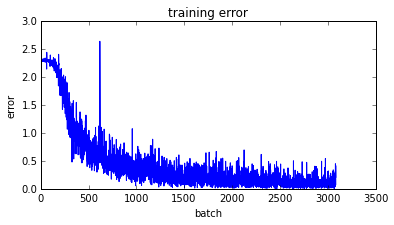

In [311]:
def graph_training_loss_history(losses):
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.ylabel('error')
    plt.xlabel('batch')
    plt.title('training error')
    plt.show()
    
graph_training_loss_history(history.losses)

In [312]:
from sklearn.metrics import log_loss
predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
score = log_loss(y_valid, predictions_valid)
print('Score log_loss: ', score)

2707/2707 [==============================] - 1s     
('Score log_loss: ', 2.4267208820625661)


In [313]:
model.save_weights('./model/saved_weights.h5')

## Predict based on the test data

As there are 79k test images, we will do this in batches of 10k just in case we run out of memory!!

In [334]:
# Load the test data
def load_test_images(test_images_dir):
    total = 0
    images = []
    image_ids = []
    test_image_list = os.listdir(test_images_dir)
    num_test_images = len(test_image_list)
    for i in range(0,num_test_images):
        filename = test_images_dir + test_image_list[i]
        image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
        images.append(image)  
        image_ids.append(test_image_list[i])
        total += 1
        if total % 100 == 0:
            print ".",
    print "\nProcesses {} rows.".format(total)
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    return images, np.array(image_ids)

#test_image_batches = split_test_data(test_images_dir)

In [335]:
test_data, test_ids = load_test_images(test_images_dir)  
print test_data.shape
print test_ids.shape


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [337]:
predictions = model.predict(test_data, batch_size = 128, verbose = 1)

79726/79726 [==============================] - 55s    


In [338]:
print predictions.shape
print predictions

(79726, 10)
[[  8.50211221e-11   2.20523578e-12   4.47203830e-09 ...,   1.74019077e-09
    3.96870509e-10   9.60177772e-07]
 [  2.62103067e-03   1.29987427e-04   7.08680891e-04 ...,   9.77601449e-05
    6.21231538e-06   3.33995355e-04]
 [  3.79865080e-01   1.29837051e-01   4.83982824e-02 ...,   1.86616555e-03
    7.92305358e-03   2.20616952e-01]
 ..., 
 [  2.76867533e-03   3.74398893e-03   5.87368906e-01 ...,   2.36220643e-01
    2.31727604e-02   2.25510690e-02]
 [  2.26885222e-05   7.77822606e-06   1.25330372e-03 ...,   3.71321328e-02
    2.79808737e-04   1.35821858e-04]
 [  1.72253722e-09   1.46282153e-09   3.01322811e-09 ...,   2.33719007e-07
    5.68030693e-04   6.32985175e-05]]


In [351]:
import datetime
def create_submission(predictions, test_ids, test_info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_ids, index=result.index)
    now = datetime.datetime.now()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = test_info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('submission', 'submission_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)

test_info = 'loss_' + str(score) \
                + '_h_' + str(image_height) \
                + '_w_' + str(image_width) \
                + '_ep_' + str(num_epochs)
create_submission(predictions, test_ids, test_info)

## Manual testing
Test an image manually to see if it gives an answer we can check by hand!

In [300]:
class_descriptions=['c0: safe driving',
    'c1: texting - right',
    'c2: talking on the phone - right',
    'c3: texting - left',
    'c4: talking on the phone - left',
    'c5: operating the radio',
    'c6: drinking',
    'c7: reaching behind',
    'c8: hair and makeup',
    'c9: talking to passenger']

In [301]:
import random 
#test_image_path = "./images/validate/0/img_96916.jpg"
def classify_image(test_image_path):
    render_image(test_image_path)
    image=np.random.random((1, 3, image_width, image_height))
    image[0]=cv2.imread(test_image_path).transpose(2,1,0)
    classes = model.predict_classes(image)
    return classes

# Randomly select images from the validation set
num_validation_examples = 10
num_validation_samples = y_valid.shape[0]
print num_validation_samples
validate_index = np.random.choice(range(0, num_validation_samples), num_validation_examples, replace = False) # Random ordering

validation_image_examples = X_valid[validate_index]
validation_image_examples_labels = y_valid[validate_index]
classes = model.predict(validation_image_examples)

print classes
print validation_image_examples_labels

#for i, c in zip(validation_image_examples, validation_image_examples_labels):
#        classes = model.predict_classes(i)    
#        print "Image classified as {} / actual = {}".format(class_descriptions[classes], class_descriptions[c])
    


3810
[[  2.30998867e-05   3.28979921e-03   2.09076155e-04   2.54052877e-01
    1.03357574e-03   3.48485315e-07   3.78804328e-03   2.15529636e-01
    2.70803832e-03   5.19365489e-01]
 [  5.20649785e-03   5.75637659e-06   2.01649815e-02   3.31760064e-04
    3.19149792e-02   2.30643956e-04   2.43182163e-04   2.28632968e-02
    9.14614975e-01   4.42393636e-03]
 [  2.89948865e-08   1.58493930e-11   1.04319971e-12   9.99999464e-01
    1.03436613e-10   3.12093931e-14   1.57568321e-14   1.37887328e-13
    2.42855569e-10   4.88470050e-07]
 [  5.41806585e-05   9.73022080e-11   1.03115613e-10   9.99760032e-01
    3.61381171e-05   1.18702326e-10   1.71246906e-10   6.51857457e-10
    1.06706415e-04   4.29559368e-05]
 [  1.35615824e-06   8.54278114e-05   7.23059929e-06   5.28817624e-03
    3.48247588e-04   1.32579327e-04   1.15880339e-05   9.84937847e-01
    1.12778647e-03   8.05973914e-03]
 [  6.35793128e-07   1.79374605e-01   2.17865454e-03   8.22083850e-04
    3.45346270e-05   4.24285186e-03   8.